Training XGBoost model...
[0]	validation_0-error:0.11266	validation_0-logloss:0.34586
[1]	validation_0-error:0.11266	validation_0-logloss:0.33476
[2]	validation_0-error:0.11266	validation_0-logloss:0.32534
[3]	validation_0-error:0.11266	validation_0-logloss:0.31868
[4]	validation_0-error:0.11266	validation_0-logloss:0.31313
[5]	validation_0-error:0.11218	validation_0-logloss:0.31185
[6]	validation_0-error:0.11036	validation_0-logloss:0.30980
[7]	validation_0-error:0.10174	validation_0-logloss:0.29667
[8]	validation_0-error:0.09967	validation_0-logloss:0.28529
[9]	validation_0-error:0.09591	validation_0-logloss:0.28652
[10]	validation_0-error:0.10016	validation_0-logloss:0.29038
[11]	validation_0-error:0.13099	validation_0-logloss:0.29155
[12]	validation_0-error:0.13306	validation_0-logloss:0.28872
[13]	validation_0-error:0.14678	validation_0-logloss:0.29203
[14]	validation_0-error:0.15163	validation_0-logloss:0.29154
[15]	validation_0-error:0.14059	validation_0-logloss:0.28491
[16]	val

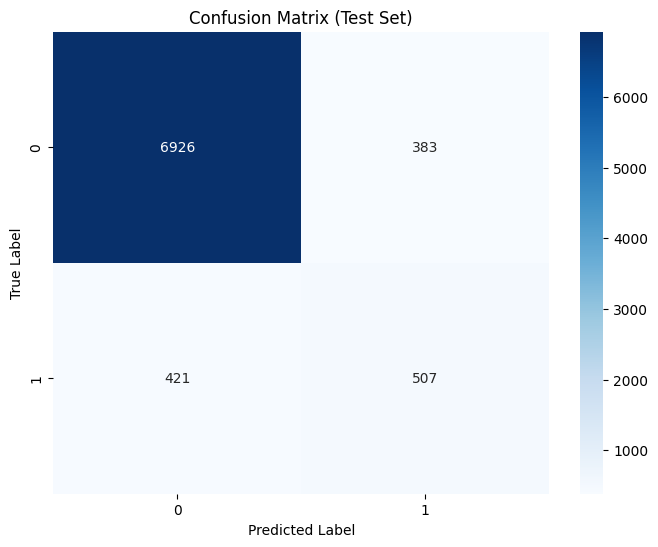

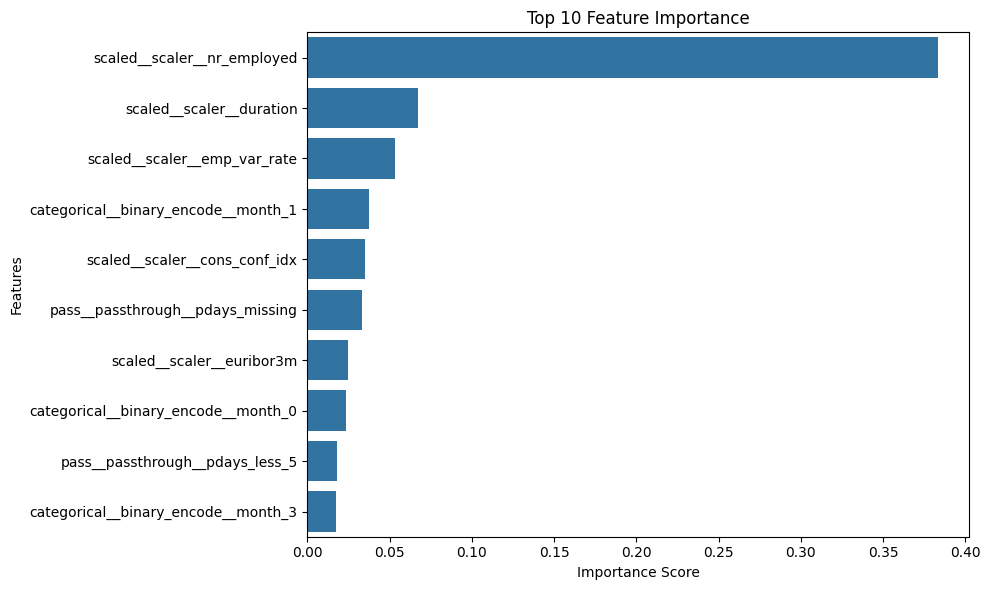


Model saved to: /home/me/Docs/c21-56-t-data-bi/models/xgboost_model.json
Feature importance saved to: /home/me/Docs/c21-56-t-data-bi/models/feature_importance.csv


In [4]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
BASE_PATH = os.path.abspath('..') 
PROCESSED_DATA_PATH = os.path.join(BASE_PATH, 'data', 'processed')
MODEL_PATH = os.path.join(BASE_PATH, 'models')

# Define file names
X_TRAIN = 'X_train.csv'
X_TEST = 'X_test.csv'
X_VALID = 'X_valid.csv'
Y_TRAIN = 'y_train.csv'
Y_TEST = 'y_test.csv'
Y_VALID = 'y_valid.csv'

# Set random seed for reproducibility
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

# Load the preprocessed data
X_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, X_TRAIN))
X_test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, X_TEST))
X_valid = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, X_VALID))

y_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, Y_TRAIN))
y_test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, Y_TEST))
y_valid = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, Y_VALID))



# Define XGBoost parameters
xgb_params = {
    'objective': 'binary:logistic',  # Binary classification
    'max_depth': 6,                  # Maximum tree depth
    'learning_rate': 0.1,            # Learning rate
    'n_estimators': 100,             # Number of boosting rounds
    'min_child_weight': 1,           # Minimum sum of instance weight needed in a child
    'subsample': 0.8,                # Subsample ratio of the training instances
    'colsample_bytree': 0.8,         # Subsample ratio of columns when constructing each tree
    'eval_metric': ['error', 'logloss'],  # Evaluation metrics to monitor
    'random_state': RANDOM_SEED,
    'callbacks': [xgb.callback.EarlyStopping(rounds=20)]  # Early stopping through callbacks
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(**xgb_params)

# Train the model
print("Training XGBoost model...")
xgb_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

# Make predictions
print("\nMaking predictions...")
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)
y_pred_valid = xgb_model.predict(X_valid)

# Calculate F1 scores for each dataset
print("\nCalculating F1 metrics...")

# Training metrics
train_f1 = f1_score(y_train, y_pred_train, average='binary')
train_f1_weighted = f1_score(y_train, y_pred_train, average='weighted')

# Testing metrics
test_f1 = f1_score(y_test, y_pred_test, average='binary')
test_f1_weighted = f1_score(y_test, y_pred_test, average='weighted')

# Validation metrics
valid_f1 = f1_score(y_valid, y_pred_valid, average='binary')
valid_f1_weighted = f1_score(y_valid, y_pred_valid, average='weighted')

# Print performance metrics
print("\nTraining Set Metrics:")
print(f"F1 Score: {train_f1:.4f}")
print(f"F1 Weighted Score: {train_f1_weighted:.4f}")

print("\nTest Set Metrics:")
print(f"F1 Score: {test_f1:.4f}")
print(f"F1 Weighted Score: {test_f1_weighted:.4f}")

print("\nValidation Set Metrics:")
print(f"F1 Score: {valid_f1:.4f}")
print(f"F1 Weighted Score: {valid_f1_weighted:.4f}")

# Print detailed classification report for test set
print("\nDetailed Classification Report (Test Set):")
print(classification_report(y_test, y_pred_test))

# Create confusion matrix for test set
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Save the trained model
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

model_file = os.path.join(MODEL_PATH, 'xgboost_model.json')
xgb_model.save_model(model_file)
print(f"\nModel saved to: {model_file}")

# Save feature importance
feature_importance.to_csv(os.path.join(MODEL_PATH, 'feature_importance.csv'), index=False)
print(f"Feature importance saved to: {os.path.join(MODEL_PATH, 'feature_importance.csv')}")